In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
color_pal = sns.color_palette()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/egx-30/EGX 30 Data June.csv


# Data Preprocessing

In [2]:
df = pd.read_csv("/kaggle/input/egx-30/EGX 30 Data June.csv")

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/05/2024,"26,634.30","26,915.46","26,915.46","26,245.33",240.86M,-1.26%
1,06/04/2024,"26,973.00","26,852.33","27,158.65","26,852.33",352.59M,0.52%
2,06/03/2024,"26,834.47","26,869.85","27,003.04","26,760.84",267.86M,-0.13%
3,06/02/2024,"26,869.85","26,922.76","27,140.20","26,753.70",225.28M,-0.20%
4,05/30/2024,"26,922.76","27,089.68","27,116.25","26,683.97",352.59M,-0.62%
...,...,...,...,...,...,...,...
3704,03/05/2009,"3,575.93","3,566.55","3,605.23","3,565.60",54.81M,0.47%
3705,03/04/2009,"3,559.09","3,524.63","3,562.48","3,524.63",68.90M,1.19%
3706,03/03/2009,"3,517.33","3,524.81","3,533.41","3,494.95",57.01M,-1.88%
3707,03/02/2009,"3,584.86","3,640.55","3,641.19","3,584.86",46.91M,-1.70%


In [4]:
def convert_volume_to_float(volume_str):
    if pd.isna(volume_str):
        return np.nan
    else:
        return float(volume_str[:-1]) * 1e6

def convert_change_to_float(change_str):
    if pd.isna(change_str):
        return np.nan
    else:
        return float(change_str[:-1]) /100

**Changing string values to float**

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

num_cols = ['Price', 'Open', 'High', 'Low']
for col in num_cols:
    df[col] = df[col].str.replace(',', '').astype(float)

df['Vol.'] = df['Vol.'].apply(convert_volume_to_float)
df['Change %']= df['Change %'].apply(convert_change_to_float)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062
...,...,...,...,...,...,...
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188


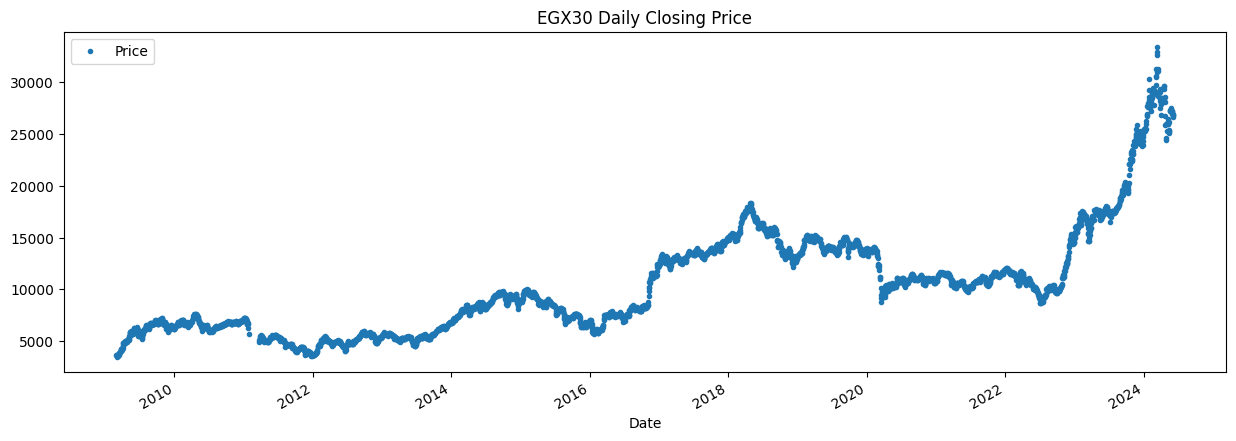

In [6]:
df.plot(y='Price', figsize=(15,5), color= color_pal[0],
        title='EGX30 Daily Closing Price', use_index=True, style='.')
plt.show()

In [7]:
def create_lag_features(df,col,lags):
    """
    Create time series features based on time series index.
    """
    df = df.sort_index()
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.sort_index(ascending= False)
    return df

df = create_lag_features(df, 'Price', [1,2,3,4,5])
df = create_lag_features(df, 'Open', [1,2,3,4,5])
df = create_lag_features(df, 'High', [1,2,3,4,5])
df = create_lag_features(df, 'Low', [1,2,3,4,5])
df = create_lag_features(df, 'Vol.', [1,2,3,4,5])
df = create_lag_features(df, 'Change %', [1,2,3,4,5])

In [8]:
df

,Price,Open,High,Low,Vol.,Change %,quarter,year,Price_lag_1,Price_lag_2,...,Vol._lag_1,Vol._lag_2,Vol._lag_3,Vol._lag_4,Vol._lag_5,Change %_lag_1,Change %_lag_2,Change %_lag_3,Change %_lag_4,Change %_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,26915.46,26915.46,26245.33,240860000.0,-0.0126,2,2024,26973.00,26834.47,...,352590000.0,267860000.0,225280000.0,352590000.0,241350000.0,0.0052,-0.0013,-0.0020,-0.0062,-0.0039
2024-06-04,26973.00,26852.33,27158.65,26852.33,352590000.0,0.0052,2,2024,26834.47,26869.85,...,267860000.0,225280000.0,352590000.0,241350000.0,277390000.0,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034
2024-06-03,26834.47,26869.85,27003.04,26760.84,267860000.0,-0.0013,2,2024,26869.85,26922.76,...,225280000.0,352590000.0,241350000.0,277390000.0,268800000.0,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091
2024-06-02,26869.85,26922.76,27140.20,26753.70,225280000.0,-0.0020,2,2024,26922.76,27089.68,...,352590000.0,241350000.0,277390000.0,268800000.0,274590000.0,-0.0062,-0.0039,-0.0034,-0.0091,0.0123
2024-05-30,26922.76,27089.68,27116.25,26683.97,352590000.0,-0.0062,2,2024,27089.68,27194.51,...,241350000.0,277390000.0,268800000.0,274590000.0,236420000.0,-0.0039,-0.0034,-0.0091,0.0123,-0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-05,3575.93,3566.55,3605.23,3565.60,54810000.0,0.0047,1,2009,3559.09,3517.33,...,68900000.0,57010000.0,46910000.0,43850000.0,NaN,0.0119,-0.0188,-0.0170,0.0137,NaN
2009-03-04,3559.09,3524.63,3562.48,3524.63,68900000.0,0.0119,1,2009,3517.33,3584.86,...,57010000.0,46910000.0,43850000.0,NaN,NaN,-0.0188,-0.0170,0.0137,NaN,NaN
2009-03-03,3517.33,3524.81,3533.41,3494.95,57010000.0,-0.0188,1,2009,3584.86,3647.02,...,46910000.0,43850000.0,NaN,NaN,NaN,-0.0170,0.0137,NaN,NaN,NaN


In [9]:
df = df.loc[df.index > '03-05-2009']
eng_features = ['Price', 'Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4', 'Price_lag_5',
                'Open_lag_1','Open_lag_2','Open_lag_3','Open_lag_4','Open_lag_5',
                'High_lag_1','High_lag_2','High_lag_3','High_lag_4','High_lag_5',
                'Low_lag_1','Low_lag_2','Low_lag_3','Low_lag_4','Low_lag_5',
                'Vol._lag_1','Vol._lag_2','Vol._lag_3','Vol._lag_4','Vol._lag_5',
                'Change %_lag_1','Change %_lag_2','Change %_lag_3','Change %_lag_4','Change %_lag_5','year','quarter']
aug_df = df[eng_features]
aug_df

,Price,Price_lag_1,Price_lag_2,Price_lag_3,Price_lag_4,Price_lag_5,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,...,Vol._lag_3,Vol._lag_4,Vol._lag_5,Change %_lag_1,Change %_lag_2,Change %_lag_3,Change %_lag_4,Change %_lag_5,year,quarter
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-05,26634.30,26973.00,26834.47,26869.85,26922.76,27089.68,26852.33,26869.85,26922.76,27089.68,...,225280000.0,352590000.0,241350000.0,0.0052,-0.0013,-0.0020,-0.0062,-0.0039,2024,2
2024-06-04,26973.00,26834.47,26869.85,26922.76,27089.68,27194.51,26869.85,26922.76,27089.68,27194.51,...,352590000.0,241350000.0,277390000.0,-0.0013,-0.0020,-0.0062,-0.0039,-0.0034,2024,2
2024-06-03,26834.47,26869.85,26922.76,27089.68,27194.51,27287.31,26922.76,27089.68,27194.51,27287.31,...,241350000.0,277390000.0,268800000.0,-0.0020,-0.0062,-0.0039,-0.0034,-0.0091,2024,2
2024-06-02,26869.85,26922.76,27089.68,27194.51,27287.31,27539.21,27089.68,27194.51,27287.31,27539.21,...,277390000.0,268800000.0,274590000.0,-0.0062,-0.0039,-0.0034,-0.0091,0.0123,2024,2
2024-05-30,26922.76,27089.68,27194.51,27287.31,27539.21,27205.14,27194.51,27287.31,27539.21,27205.14,...,268800000.0,274590000.0,236420000.0,-0.0039,-0.0034,-0.0091,0.0123,-0.0008,2024,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-15,3819.56,3700.76,3712.82,3627.77,3587.46,3575.93,3697.08,3747.98,3592.62,3576.95,...,65660000.0,38000000.0,54810000.0,-0.0032,0.0234,0.0112,0.0032,0.0047,2009,1
2009-03-12,3700.76,3712.82,3627.77,3587.46,3575.93,3559.09,3747.98,3592.62,3576.95,3566.55,...,38000000.0,54810000.0,68900000.0,0.0234,0.0112,0.0032,0.0047,0.0119,2009,1
2009-03-11,3712.82,3627.77,3587.46,3575.93,3559.09,3517.33,3592.62,3576.95,3566.55,3524.63,...,54810000.0,68900000.0,57010000.0,0.0112,0.0032,0.0047,0.0119,-0.0188,2009,1


In [10]:
print(df.index.dtype)

datetime64[ns]


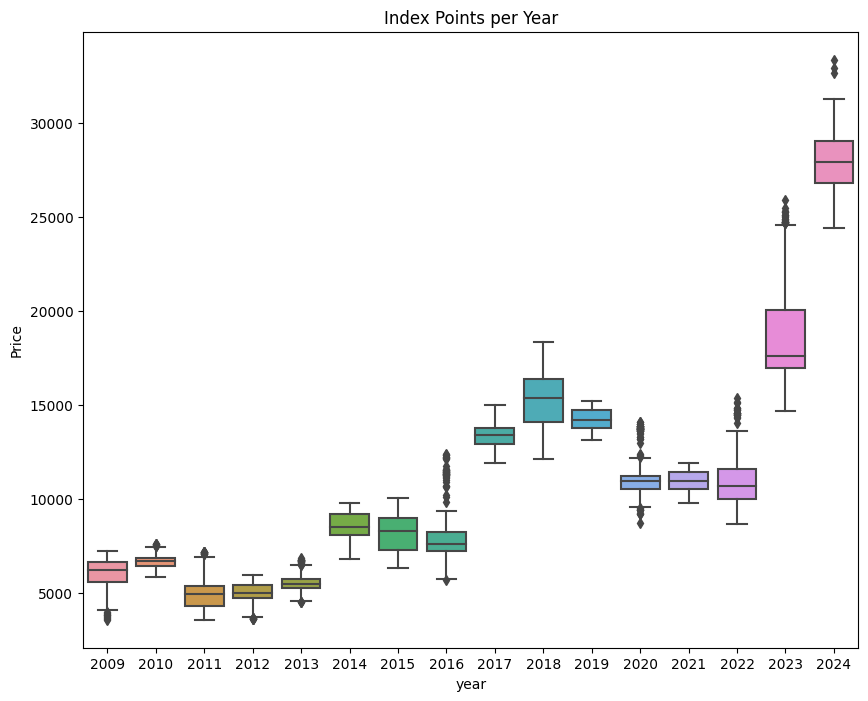

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='year', y='Price')
ax.set_title('Index Points per Year')
plt.show()

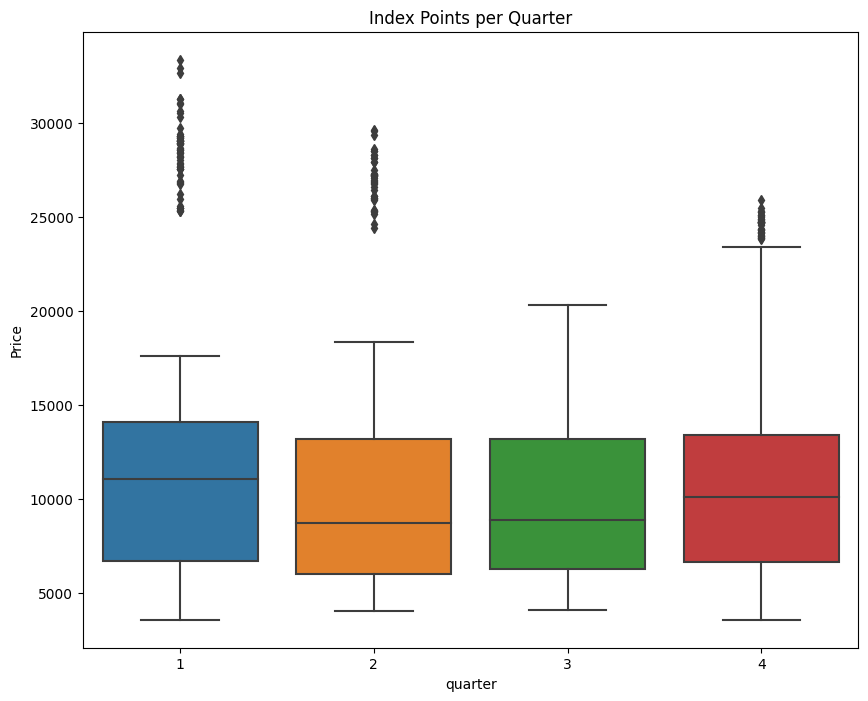

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='quarter', y='Price')
ax.set_title('Index Points per Quarter')
plt.show()

In [14]:
aug_df.columns

Index(['Price', 'Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4',
       'Price_lag_5', 'Open_lag_1', 'Open_lag_2', 'Open_lag_3', 'Open_lag_4',
       'Open_lag_5', 'High_lag_1', 'High_lag_2', 'High_lag_3', 'High_lag_4',
       'High_lag_5', 'Low_lag_1', 'Low_lag_2', 'Low_lag_3', 'Low_lag_4',
       'Low_lag_5', 'Vol._lag_1', 'Vol._lag_2', 'Vol._lag_3', 'Vol._lag_4',
       'Vol._lag_5', 'Change %_lag_1', 'Change %_lag_2', 'Change %_lag_3',
       'Change %_lag_4', 'Change %_lag_5', 'year', 'quarter'],
      dtype='object')

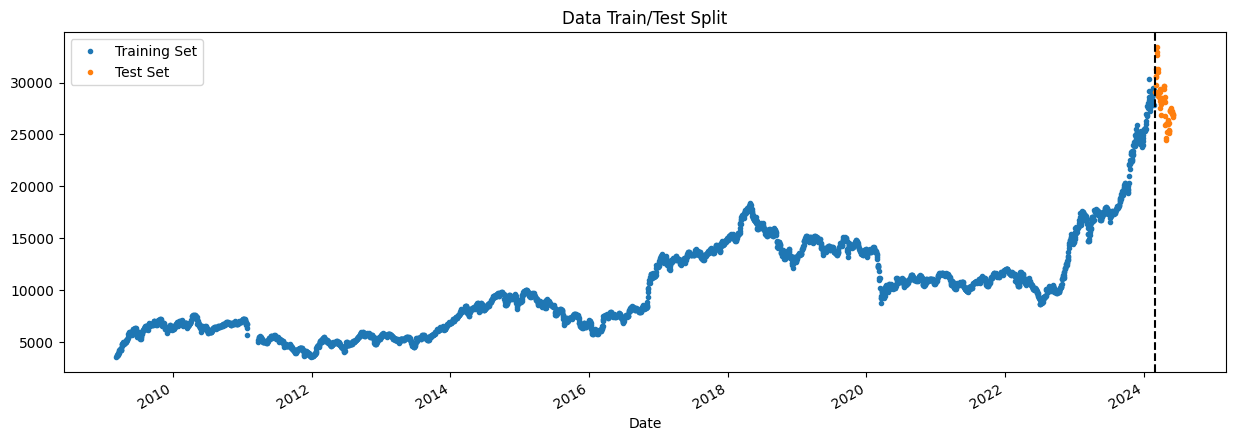

In [15]:
#train = create_features(train)
#test = create_features(test)
train = aug_df.loc[aug_df.index < '03-01-2024']
test = aug_df.loc[aug_df.index >= '03-01-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Price', label='Training Set', title= 'Data Train/Test Split', style='.')
test.plot(ax=ax, y='Price', label='Test Set', style='.')
ax.axvline('03-01-2024', color='black', ls='--')
plt.show()

train_features = ['Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4', 'Price_lag_5',
                'Open_lag_1','Open_lag_2','Open_lag_3','Open_lag_4','Open_lag_5',
                'High_lag_1','High_lag_2','High_lag_3','High_lag_4','High_lag_5',
                'Low_lag_1','Low_lag_2','Low_lag_3','Low_lag_4','Low_lag_5',
                'Vol._lag_1','Vol._lag_2','Vol._lag_3','Vol._lag_4','Vol._lag_5',
                'Change %_lag_1','Change %_lag_2','Change %_lag_3','Change %_lag_4','Change %_lag_5','year','quarter']

X_train = train[train_features]
Y_train = train['Price']

X_test = test[train_features]
Y_test = test['Price']

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1100,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

[0]	validation_0-rmse:11020.52236	validation_1-rmse:27828.28626
[100]	validation_0-rmse:4077.60166	validation_1-rmse:11183.91208
[200]	validation_0-rmse:1517.78616	validation_1-rmse:4674.25615
[300]	validation_0-rmse:581.68726	validation_1-rmse:2302.06626
[400]	validation_0-rmse:258.82773	validation_1-rmse:1590.21861
[500]	validation_0-rmse:167.16984	validation_1-rmse:1421.79214
[600]	validation_0-rmse:146.01953	validation_1-rmse:1353.92968
[700]	validation_0-rmse:139.77455	validation_1-rmse:1318.31157
[800]	validation_0-rmse:136.27110	validation_1-rmse:1301.04984
[900]	validation_0-rmse:133.56521	validation_1-rmse:1286.95251
[1000]	validation_0-rmse:131.26348	validation_1-rmse:1281.42517
[1071]	validation_0-rmse:129.88356	validation_1-rmse:1278.36492


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1100, n_jobs=None,
             num_parallel_tree=None, random_state=59, ...)

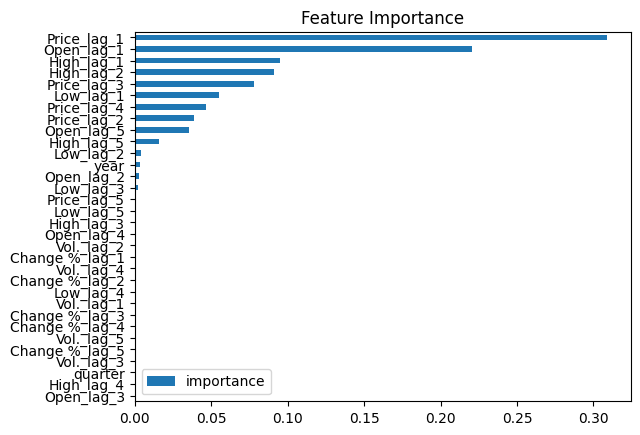

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

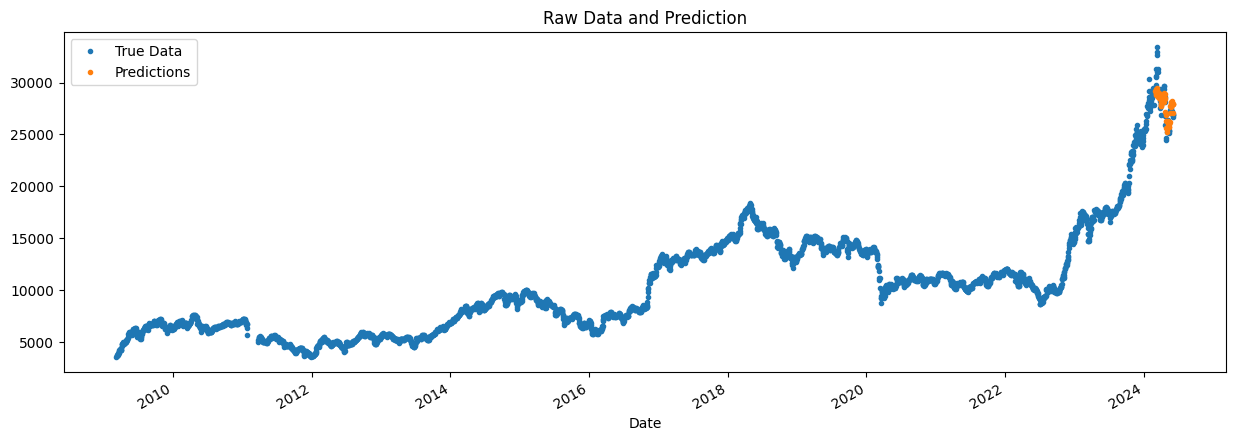

In [21]:
test.loc[:,'prediction'] = reg.predict(X_test)
aug_df = aug_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = aug_df[['Price']].plot(figsize=(15, 5), style='.')
aug_df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [22]:
test['prediction'].head(40)

Date
2024-06-05    27972.691406
2024-06-04    27077.457031
2024-06-03    27914.080078
2024-06-02    27893.867188
2024-05-30    27952.279297
2024-05-29    28035.902344
2024-05-28    27814.269531
2024-05-27    28184.431641
2024-05-26    27893.773438
2024-05-23    28109.873047
2024-05-22    27604.134766
2024-05-21    27740.060547
2024-05-20    27052.671875
2024-05-19    26157.152344
2024-05-16    26009.728516
2024-05-15    26083.259766
2024-05-14    26043.105469
2024-05-13    25670.662109
2024-05-12    25679.541016
2024-05-09    25849.277344
2024-05-08    25963.304688
2024-05-07    26278.779297
2024-05-02    25514.064453
2024-05-01    25214.990234
2024-04-30    26314.929688
2024-04-29    25636.503906
2024-04-28    26883.296875
2024-04-24    27123.484375
2024-04-23    28447.808594
2024-04-22    28890.953125
2024-04-21    28544.673828
2024-04-18    28972.703125
2024-04-17    28923.900391
2024-04-16    28901.257812
2024-04-15    28103.607422
2024-04-08    28459.574219
2024-04-07    28423.412

In [23]:
np.sqrt(mean_squared_error(test['Price'], test['prediction']))

1278.3065801301066

In [24]:
avg_price = test['Price'].mean()
avg_price

28013.045161290323

# Normalized

In [25]:
train2 = aug_df.loc[aug_df.index < '03-01-2024']
test2 = aug_df.loc[aug_df.index >= '03-01-2024']

train_features2 = ['Price_lag_1', 'Price_lag_2', 'Price_lag_3', 'Price_lag_4', 'Price_lag_5',
                'Open_lag_1','Open_lag_2','Open_lag_3','Open_lag_4','Open_lag_5',
                'High_lag_1','High_lag_2','High_lag_3','High_lag_4','High_lag_5',
                'Low_lag_1','Low_lag_2','Low_lag_3','Low_lag_4','Low_lag_5',
                'Vol._lag_1','Vol._lag_2','Vol._lag_3','Vol._lag_4','Vol._lag_5',
                'Change %_lag_1','Change %_lag_2','Change %_lag_3','Change %_lag_4','Change %_lag_5','year','quarter']

X_train2 = train2[train_features2]
Y_train2 = train2['Price']

X_test2 = test2[train_features2]
Y_test2 = test2['Price']

In [27]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(X_train2)
X_test_scaled = feature_scaler.transform(X_test2)

Y_train_scaled = target_scaler.fit_transform(Y_train2.values.reshape(-1, 1)).flatten()
Y_test_scaled = target_scaler.transform(Y_test2.values.reshape(-1, 1)).flatten()

test2.loc[:,'Price_scaled'] = Y_test_scaled

In [30]:
reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1200,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
reg2.fit(X_train_scaled, Y_train_scaled, eval_set=[(X_train_scaled, Y_train_scaled), (X_test_scaled, Y_test_scaled)], verbose=100)

test2.loc[:,'prediction_scaled'] = reg2.predict(X_test_scaled)
test2.loc[:,'prediction'] = target_scaler.inverse_transform(test2['prediction_scaled'].values.reshape(-1, 1)).flatten()

[0]	validation_0-rmse:1.10713	validation_1-rmse:3.37308
[100]	validation_0-rmse:0.41911	validation_1-rmse:1.42267
[200]	validation_0-rmse:0.16229	validation_1-rmse:0.66654
[300]	validation_0-rmse:0.06937	validation_1-rmse:0.39548
[400]	validation_0-rmse:0.04055	validation_1-rmse:0.31997
[500]	validation_0-rmse:0.03328	validation_1-rmse:0.30093
[600]	validation_0-rmse:0.03121	validation_1-rmse:0.28993
[700]	validation_0-rmse:0.03025	validation_1-rmse:0.28304
[800]	validation_0-rmse:0.02956	validation_1-rmse:0.27976
[900]	validation_0-rmse:0.02894	validation_1-rmse:0.27769
[1000]	validation_0-rmse:0.02849	validation_1-rmse:0.27595


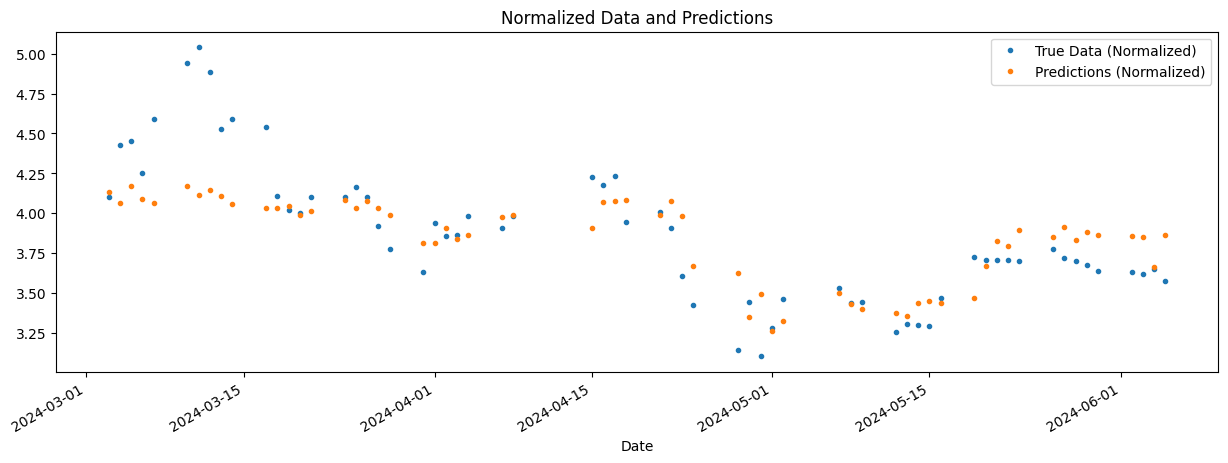

In [31]:
import matplotlib.pyplot as plt

# Plot normalized data and predictions
fig, ax = plt.subplots(figsize=(15, 5))

# Plot true data
test2['Price_scaled'].plot(ax=ax, style='.', label='True Data (Normalized)')

# Plot predictions
test2['prediction_scaled'].plot(ax=ax, style='.', label='Predictions (Normalized)')

plt.legend()
plt.title('Normalized Data and Predictions')
plt.show()

In [32]:
np.sqrt(mean_squared_error(test2['Price_scaled'], test2['prediction_scaled']))

0.2758894764545277